## 1. Import Packages

In [1]:
import pickle
import os 

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from utils.preprocess import process_raw_data, get_all_data, get_reviews_in_idx
from utils.word2vec_helper import get_word_vec
from utils.path_helper import ROOT_DIR
from data_utils import ReviewDataLoader
from deepconn_tf import DeepCoNN, DeepCoNNConfig

## 2. Data Preprocess

In [3]:
process_raw_data()
train_data, test_data = get_all_data()
word_vec = get_word_vec()

user_review, item_review = get_reviews_in_idx(train_data, word_vec)
pickle.dump(user_review, open(ROOT_DIR.joinpath("data/user_review_word_idx.p"), "wb"))
pickle.dump(item_review, open(ROOT_DIR.joinpath("data/item_review_word_idx.p"), "wb"))

2023-11-02 16:06:27,120 [INFO] preprocess.py:92 - reading raw data...
/home/jongwook95.lee/study/text_based_user_item_recommendation/utils/preprocess.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_meta['trip_type'][pandas.isna(df_user_meta['trip_type'])] = "Unknown"
/home/jongwook95.lee/study/text_based_user_item_recommendation/utils/preprocess.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_meta['User_contributions_num'][pandas.isna(df_user_meta['User_contributions_num'])] = 0
/home/jongwook95.lee/study/text_based_user_item_recommendation/utils/preprocess.py:102: SettingWithCopyWarning: 
A

## 3. Define Config

In [2]:
config = DeepCoNNConfig(
    data_path="data/reviews.json",
    user_path="data/user_review_word_idx.p",
    item_path="data/item_review_word_idx.p",
    user_meta_path="data/user_meta_dict.p",
    item_meta_path="data/item_meta_dict.p",
    embedding_path="data/GoogleNews-vectors-negative300.bin",
    num_epochs=1,
    batch_size=4,
    learning_rate=1e-3,
    l2_regularization=1e-2,
    weight_decay=0.95,
    max_review_length=512,  # Make sure this value is smaller than max_length in data_reader.py
    word_dim=300,
    kernel_widths=[2, 3, 5, 7],
    kernel_deep=100,
    latent_factors=50,
    fm_k=8,
    user_meta_dim=9,
    item_meta_dim=149
)

## 4. Build Model

2023-11-02 16:48:29,377 [INFO] word2vec_helper.py:37 - loading word2vec model...
2023-11-02 16:48:47,044 [CRITICAL] word2vec_helper.py:41 - PAD_WORD_ID is 3000000.
2023-11-02 16:48:47,045 [INFO] word2vec_helper.py:42 - word2vec model loaded.
2023-11-02 16:48:47.106131: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 16:48:48.083085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6966 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-11-02 16:48:48.083628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7379

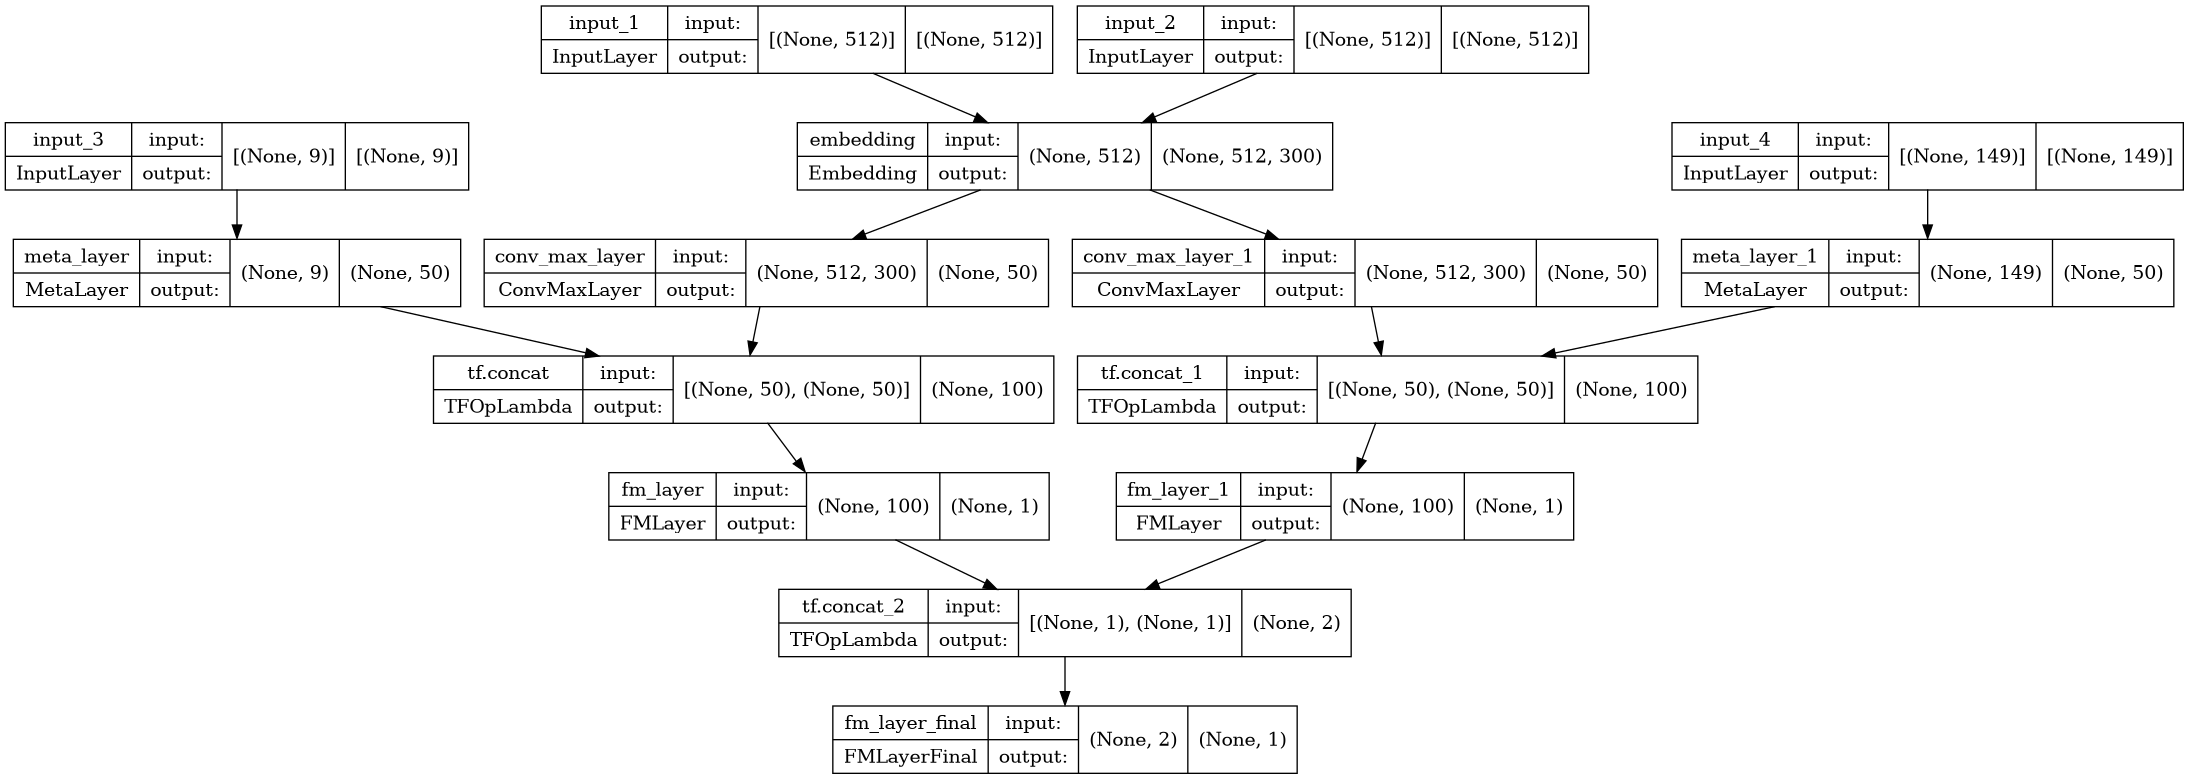

In [3]:
word_vec = get_word_vec(path=config.embedding_path)

model = DeepCoNN(config = config, embedding_weight=word_vec)
model = model.build(input_shapes=((config.max_review_length),
                                  (config.max_review_length),
                                  (config.user_meta_dim),
                                  (config.item_meta_dim)
    )
)

plot_model(model, to_file="model.png", expand_nested=True, show_shapes=True)

In [20]:
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate=config.learning_rate, beta_1=config.weight_decay) 
epochs = config.num_epochs

os.makedirs('result', exist_ok = True)
os.makedirs('result/checkpoint', exist_ok = True)
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True)

## 5. Make DataGenerators

In [21]:
train_data, test_data = get_all_data(path=config.data_path)
train_dataloader = ReviewDataLoader(data=train_data.iloc[:400, :],
                batch_size=config.batch_size,
                shuffle=True,
                config=config)

test_dataloader = ReviewDataLoader(data=test_data.iloc[:400, :],
                batch_size=1,
                shuffle=False, 
                config=config)

## 6. Train Model

In [22]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[loss_fn])
model.fit(train_dataloader, validation_data=test_dataloader, epochs=epochs)
#model.fit(train_dataloader, validation_data=test_dataloader, epochs=epochs, callbacks=[model_checkpoint_callback])


100/100 [==============================] - ETA: 0s - loss: 0.1031 - mean_squared_error: 0.1031

NotImplementedError: 

## 7. Evaluation

In [8]:
model = keras.models.load_model("result/checkpoint/best_model.hdf5", compile = False)

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x7efe6c0fd7c0>.

In [19]:
print("Evaluate on test data")
results = model.evaluate(test_dataloader)
print("test MSE:", results[0])

Evaluate on test data
400/400 [==============================] - 2s 5ms/step - loss: 0.1084 - mean_squared_error: 0.1084
test MSE: 0.10843750089406967
